In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import seaborn as sns; sns.set_style("whitegrid")
import scipy
import scipy.stats as ss
from sklearn import metrics
import scanpy
import os
import itertools
from tqdm import tqdm; tqdm.pandas()

from matplotlib import font_manager as fm
fm.fontManager.addfont('Arial.ttf')
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Arial"]

%matplotlib inline

# Real data

Replogle 2022, bulk.

## Overview

In [2]:
root = '../../../../data/GWPS-Replogle'

norm_bulk = os.path.join(root, 'processed', 'K562_gwps_normalized_bulk_01.h5ad')
bulk = scanpy.read_h5ad(norm_bulk, backed='r').to_memory()

pvalues = pd.read_csv(os.path.join(root, 
                                   'supplement', 
                                   'anderson-darling p-values, BH-corrected.csv.gz'),
                      index_col=0)

# keep (deduplicated) non-control probes that target primary transcripts and correspond to measured genes
# - cf. Fig1 notebook
remove = ['8769_ELOB_P1P2_ENSG00000103363','5047_MIA2_P1P2_ENSG00000150527','8535_BHLHE40_P1P2_ENSG00000134107']

guides, genes = zip(*[(g,g.split('_')[-1]) for g in pvalues.columns if ~bulk.obs.loc[g,'core_control'] \
                                                                    and 'P1' in g.split('_')[2] \
                                                                    and g.split('_')[-1] in pvalues.index \
                                                                    and g not in remove
                     ])

# Pandas DataFrame, with symmetric rows and columns -- the diagonal has meaning!!
pval = pvalues.loc[genes, guides].T
display(pvalues.shape, 
        pval.shape, 
        pd.concat((pval.columns[:5].to_series().reset_index()[0], 
                   pval.index[:5].to_series().reset_index()[0]), 
                  axis=1))

(5530, 11258)

(5247, 5247)

,0,0
0,ENSG00000109861,1946_CTSC_P1P2_ENSG00000109861
1,ENSG00000273559,1973_CWC25_P1P2_ENSG00000273559
2,ENSG00000143553,8210_SNAPIN_P1P2_ENSG00000143553
3,ENSG00000004534,7183_RBM6_P1P2_ENSG00000004534
4,ENSG00000005100,2209_DHX33_P1P2_ENSG00000005100


# Synthetic networks

## Overview

In [3]:
networks=pd.read_csv('../../../../projects/genetwork/grn-paper/networks.tsv', sep='\t', index_col=0)
networks[['r','delta_in','delta_out','w']] = networks[['r','delta_in','delta_out','w']].astype(int)

# in this matrix, rows are KOs and columns are genes: (i,j) is the effect KO i has on gene j
ko = np.load('../../../../projects/genetwork/grn-paper/ko.npy', mmap_mode='r')
rna = np.load('../../../../projects/genetwork/grn-paper/rna.npy', mmap_mode='r')

ko.shape, rna.shape

((1920, 2000, 2000), (1920, 2000))

In [4]:
# filter lowly expressed genes -- these aren't really kept in the real data
lowE = (rna < 1e-4)
lowE_ps = (bulk.var.loc[pval.columns,'mean'] < 0.1).values

ko.shape[1]*(1-lowE.mean()), pval.shape[1]*(1-lowE_ps.mean())

(1976.6828125, 5247.0)

## Match simulations and data on (normalized) perturbation data

In [5]:
# ignore effects on the diagonal: these measure KD efficiency in real data
v = 0.05
np.fill_diagonal(pval.values, 1)
ps_tg = (pval.iloc[~lowE_ps, ~lowE_ps] < v).mean(axis=0)
ps_ko = (pval.iloc[~lowE_ps, ~lowE_ps] < v).mean(axis=1)
q_ps  = ps_tg.mean()
print(q_ps)

# the diagonal measures self-effects in the simulations
highE_n = (~lowE).sum(axis=1)
I_grn = [np.eye(highE_n[ix], dtype=bool) for ix in range(networks.shape[0])]
p_grn = [np.quantile(np.abs(ko[ix,:,:][np.ix_(~lowE[ix,:], ~lowE[ix,:])][~I_grn[ix]]), q=1-q_ps) for ix in tqdm(range(networks.shape[0]))]

# computato
networks['tg_array0'] = [(np.ma.masked_array(np.abs(ko[ix,:,:][np.ix_(~lowE[ix,:], ~lowE[ix,:])]), # *rna[ix,:]
                                             mask = I_grn[ix]) > p_grn[ix]).mean(axis=0).data for ix in tqdm(range(networks.shape[0]))]
networks['ko_array0'] = [(np.ma.masked_array(np.abs(ko[ix,:,:][np.ix_(~lowE[ix,:], ~lowE[ix,:])]),# *rna[ix,:]
                                             mask = I_grn[ix]) > p_grn[ix]).mean(axis=1).data for ix in tqdm(range(networks.shape[0]))]

0.03144523326406235


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1920/1920 [01:40<00:00, 19.20it/s]


In [6]:
# statistical testing
networks['tg_ks0'] = networks['tg_array0'].progress_apply(lambda x: ss.kstest(x, ps_tg, mode='asymp').pvalue)
networks['ko_ks0'] = networks['ko_array0'].progress_apply(lambda x: ss.kstest(x, ps_ko, mode='asymp').pvalue)
networks['pct_ko'] = networks['tg_array0'].apply(lambda x: np.mean(x))

cols=['r','k','w','delta_in','delta_out','tg_ks0','ko_ks0']
exs = pd.concat([networks.sort_values('tg_ks0').tail(5), networks.sort_values('ko_ks0').tail(5)])
exs[cols]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1920/1920 [00:05<00:00, 377.92it/s]


,r,k,w,delta_in,delta_out,tg_ks0,ko_ks0
10,2,5,90,10,1,3.721794e-07,0.000000e+00
258,2,10,900,10,10,1.723393e-06,0.000000e+00
527,4,10,400,30,1,1.245757e-04,0.000000e+00
11,2,5,400,10,1,1.606738e-04,0.000000e+00
498,4,10,900,10,1,1.963097e-02,0.000000e+00
278,2,5,9,30,10,3.420384e-62,9.718168e-11
724,4,1,90,10,10,1.943029e-155,1.000517e-10
319,2,50,1,100,10,3.385651e-79,1.073877e-10
309,2,5,40,100,10,3.894536e-51,1.077704e-10
785,4,1,400,100,10,2.161638e-125,1.353881e-10


# Figure 5

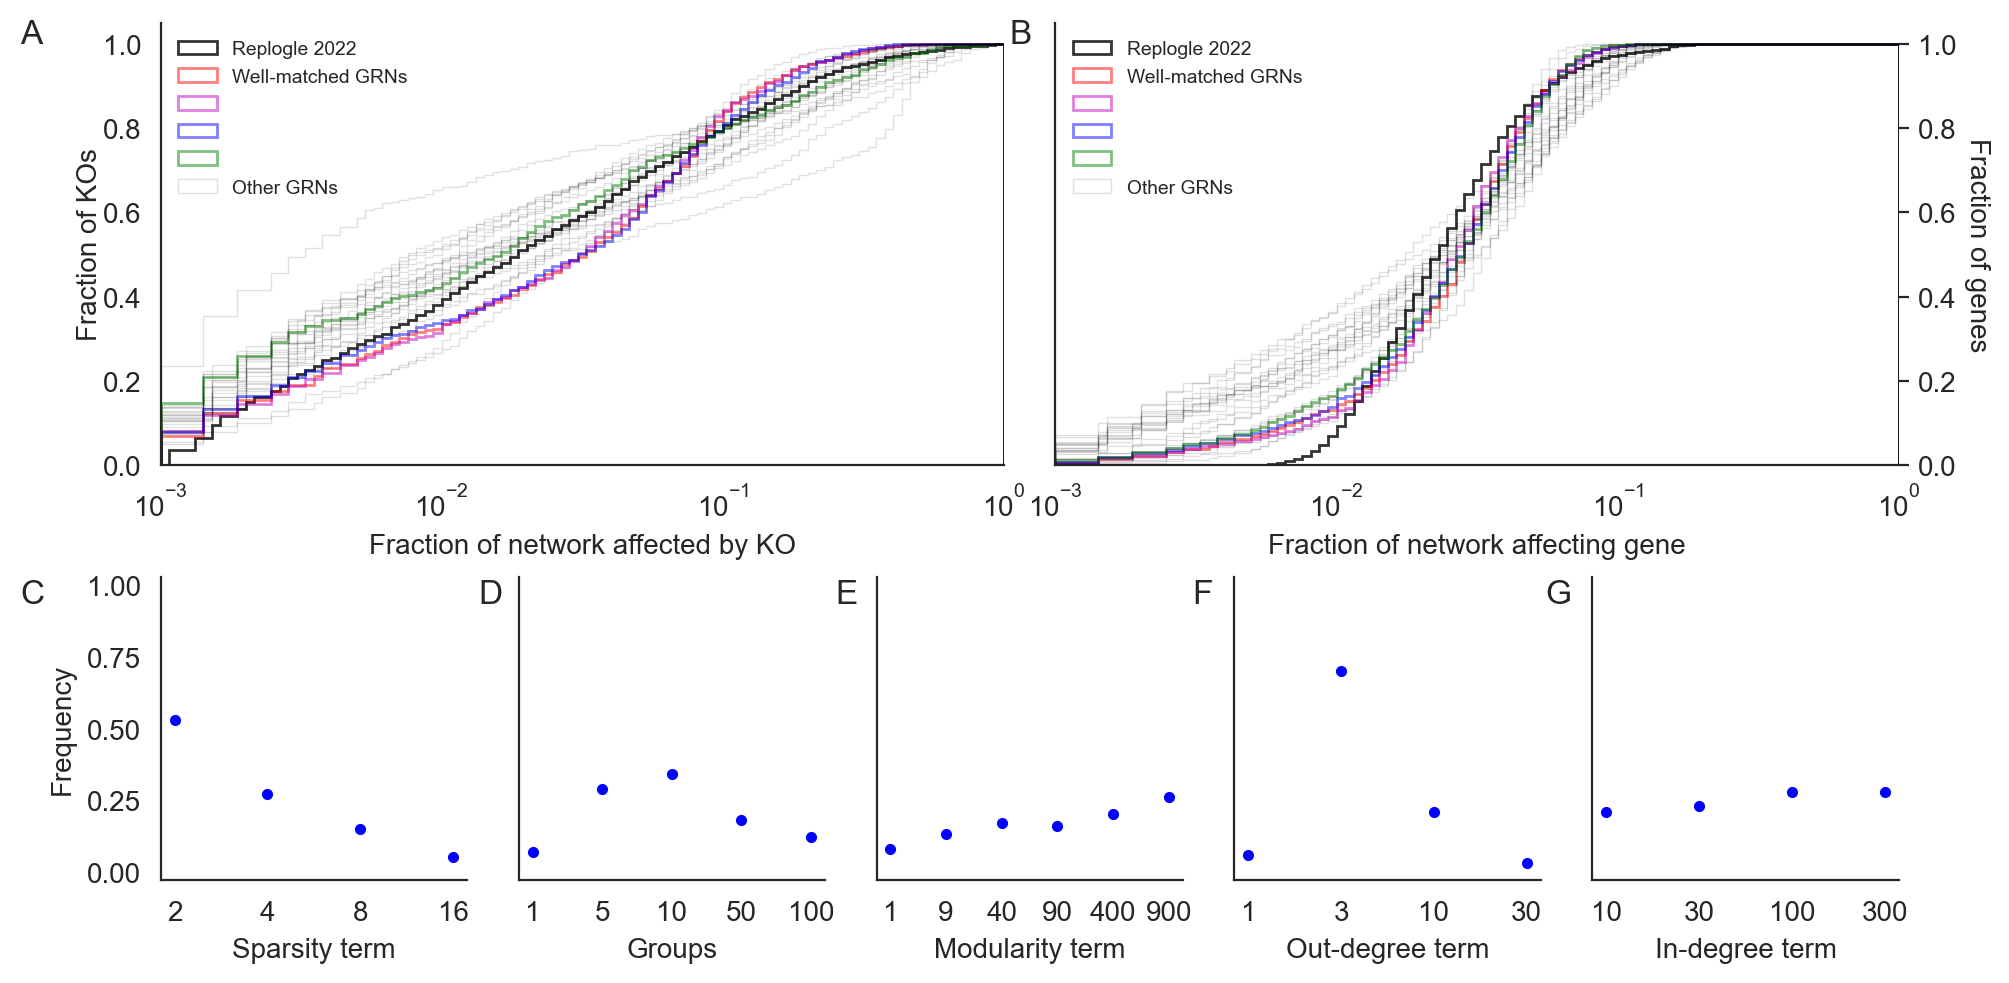

In [7]:
fig = plt.figure(figsize=(10,5), dpi=200)

grid = gs.GridSpec(7, 10, figure=fig)

sns.set_style('white');

# select good grns (closest to data by rank)
k = 4
while (networks[['tg_ks0', 'ko_ks0']].rank(ascending=False) < k).all(axis=1).sum() < 4:
    k += 1
k_good = k
good_grns = networks.loc[(networks[['tg_ks0', 'ko_ks0']].rank(ascending=False) < k_good).all(axis=1),:].sample(4)

# relax to find ok grns (for background distribution)
while (networks[['tg_ks0', 'ko_ks0']].rank(ascending=False) < k).all(axis=1).sum() < 100:
    k += 1
k_ok = k
ok_grns = networks.loc[(networks[['tg_ks0', 'ko_ks0']].rank(ascending=False) < k_ok).all(axis=1),:].sample(100)

# second background distribution 
other_grns = networks.drop(index=good_grns.index).sample(25)

ax = [None for _ in range(7)]
for i,labels in enumerate([{'x':'Fraction of network affected by KO', 'y':'Fraction of KOs', 'col':'ko_array0', 'ps':ps_ko},
                           {'x':'Fraction of network affecting gene', 'y':'Fraction of genes', 'col':'tg_array0', 'ps':ps_tg}]):
    ax[i] = fig.add_subplot(grid[:-3,(5*i):(5*(i+1))])
    for sim in range(1):
        _, bins, _ = ax[i].hist(labels['ps'],
                                alpha=0.8,
                                color='k',
                                histtype='step',
                                bins=np.logspace(-3,0,100),
                                cumulative=1,
                                density=1,
                                label='Replogle 2022' if sim==0 else '')

    for n,ix in enumerate(good_grns.index):
        ax[i].hist(networks.loc[ix, labels['col']],
                   alpha=0.5,
                   linewidth=1,
                   color='rmbg'[n],
                   histtype='step',
                   bins=bins, 
                   cumulative=1, 
                   density=1,
                   label='Well-matched GRNs' if n==0 else ' ')

    for n,ix in enumerate(other_grns.index): #
        ax[i].hist(networks.loc[ix, labels['col']],
                   alpha=0.12,
                   linewidth=0.5,
                   color='k',
                   histtype='step',
                   bins=bins, 
                   cumulative=1, 
                   density=1,
                   label='Other GRNs' if n==0 else '')    

    ax[i].legend(fontsize='x-small', loc='upper left', frameon=False)
    ax[i].semilogx();
    ax[i].set_xlim(1e-3, 1);
    ax[i].set_xlabel(labels['x'])
    ax[i].set_ylabel(labels['y'], rotation=90 if i==0 else 270, labelpad=0 if i==0 else 12)
    if i==1:
        ax[i].yaxis.tick_right();
        ax[i].yaxis.set_label_position('right');

for i,(stat,label) in enumerate(zip(['r','k','w','delta_out','delta_in'],
                                    ['Sparsity term','Groups','Modularity term','Out-degree term', 'In-degree term'])):
    ax[i+2] = fig.add_subplot(grid[-3:,(2*i):(2*(i+1))])

    pct=True
    freqs = dict(ok_grns[stat].value_counts()/(ok_grns.shape[0] if pct else 1.))
    xvals = networks[stat].unique()
    ax[i+2].plot(np.arange(len(xvals)), [freqs.get(x, 0) for x in xvals], 'b.');
    if i==0:
        ax[i+2].set_ylabel('Frequency' if pct else 'No. of GRNs');
    else:
        ax[i+2].set_yticklabels([]);
    ax[i+2].set_ylim(np.array([-0.03, 1.03])*(1 if pct else ok_grns.shape[0]));
    ax[i+2].set_yticks([f if pct else int(f*ok_grns.shape[0]) for f in [0, 0.25, 0.5, 0.75, 1]]);
    ax[i+2].set_xlabel(label);
    ax[i+2].set_xticks(np.arange(len(xvals)));
    ax[i+2].set_xticklabels(map(str, xvals));
    ax[i+2].set_in_layout(False)

sns.despine()
fig.tight_layout(h_pad=0.6, w_pad=0.1);

if True:
    fig.text(0, 0.95, 'A', fontsize=12);
    fig.text(0.495, 0.95, 'B', fontsize=12);
    fig.text(0, 0.39, 'C', fontsize=12);
    fig.text(0.18+0.055, 0.39, 'D', fontsize=12, horizontalalignment='center');
    fig.text(0.358+0.055, 0.39, 'E', fontsize=12, horizontalalignment='center');
    fig.text(0.536+0.055, 0.39, 'F', fontsize=12, horizontalalignment='center');
    fig.text(0.714+0.055, 0.39, 'G', fontsize=12, horizontalalignment='center');
    plt.savefig('png/fig5.png');

## Alternate Version

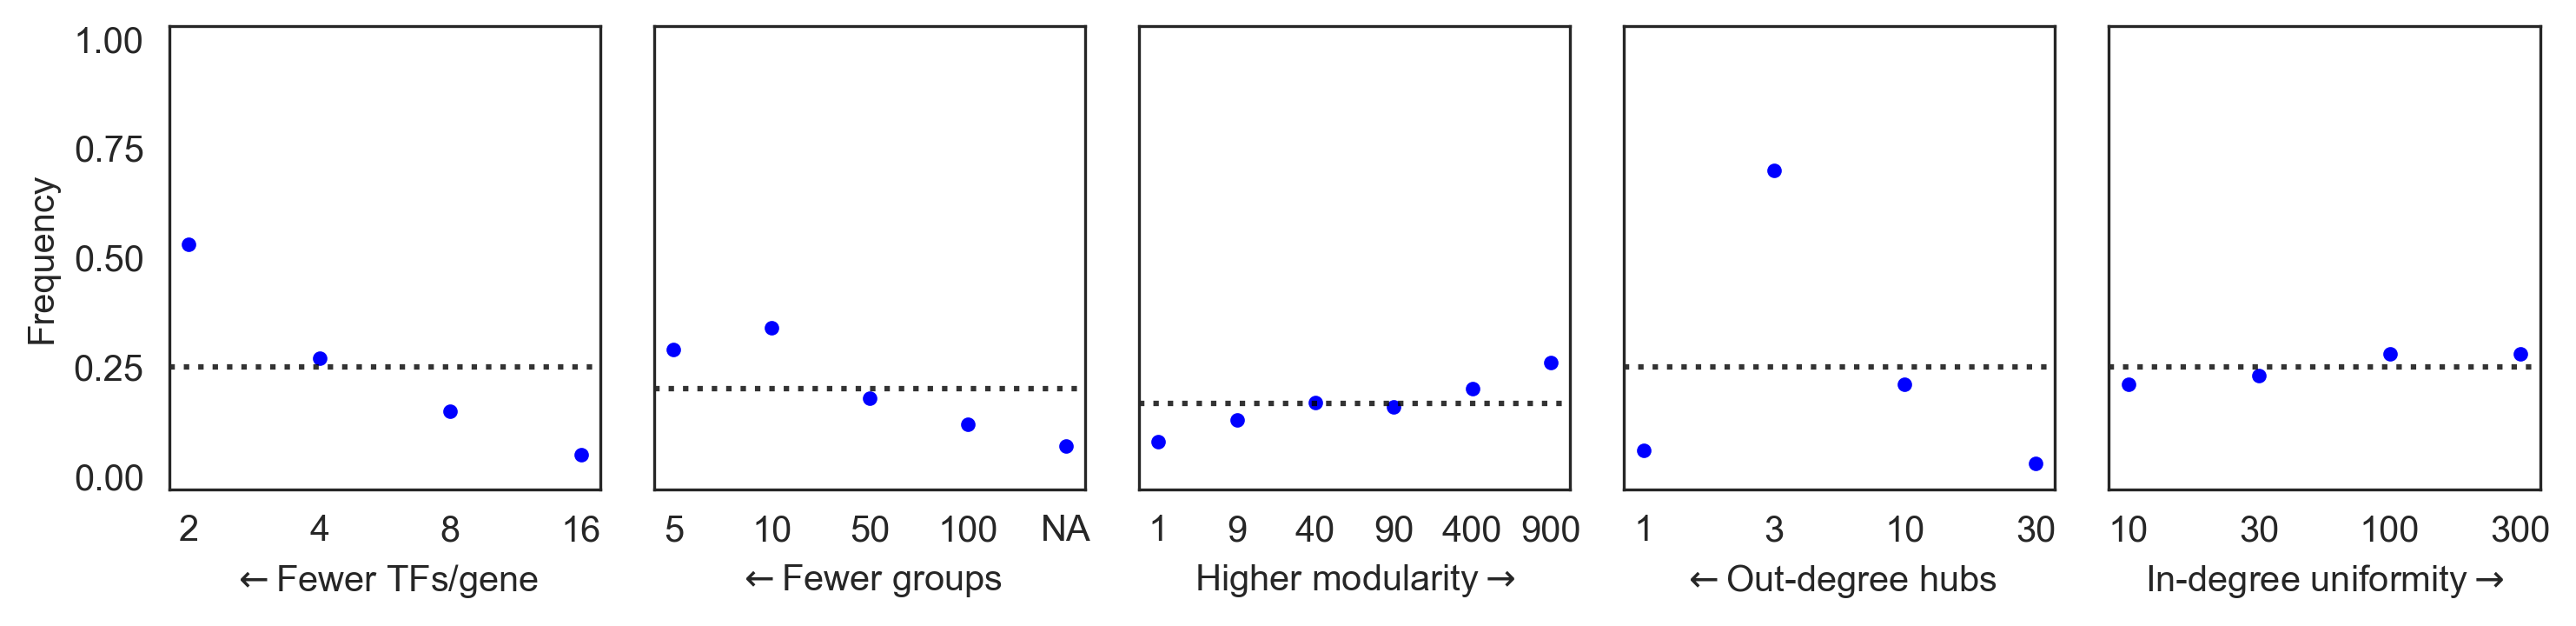

In [8]:
names=[r'$1/p$'+'\n'+r'$\leftarrow$'+' Fewer TFs per gene', 
       '',
       r'$w$'+'\nHigher modularity '+r'$\rightarrow$',
       r'$\delta_{out}$'+'\n'+r'$\leftarrow$'+' More hub regulators',
        r'$\delta_{in}$'+'\nMore Poisson-like in-degree '+r'$\rightarrow$',
]

fig, ax = plt.subplots(1, 5, figsize=(10,2.5), dpi=300);

networks['k_adj'] = networks['k'].replace({1:2000})
ok_grns['k_adj'] = ok_grns['k'].replace({1:2000})

for i,(stat,label) in enumerate(zip(['r','k_adj','w','delta_out','delta_in'],
                                    [r'$\leftarrow$'+'Fewer TFs/gene',
                                     r'$\leftarrow$'+'Fewer groups',
                                     'Higher modularity'+r'$\rightarrow$',
                                     r'$\leftarrow$'+'Out-degree hubs',
                                     'In-degree uniformity'+r'$\rightarrow$'
                                     ])):
    pct=True
    freqs = dict(ok_grns[stat].value_counts()/(ok_grns.shape[0] if pct else 1.))
    xvals = sorted(networks[stat].unique())
    ax[i].plot(np.arange(len(xvals)), [freqs.get(x, 0) for x in xvals], 'b.');
    if i==0:
        ax[i].set_ylabel('Frequency' if pct else 'No. of GRNs');
    else:
        ax[i].set_yticklabels([]);
    #ax[i+2].yaxis.tick_right();
    #ax[i+2].yaxis.set_label_position('right');
    ax[i].set_ylim(np.array([-0.03, 1.03])*(1 if pct else ok_grns.shape[0]));
    ax[i].set_yticks([f if pct else int(f*ok_grns.shape[0]) for f in [0, 0.25, 0.5, 0.75, 1]]);
    ax[i].set_xlabel(label);
    ax[i].set_xticks(np.arange(len(xvals)));
    ax[i].set_xticklabels([str(x) if x != 2000 else 'NA' for x in xvals]);
    ax[i].axhline((1 if pct else ok_grns.shape[0])/len(xvals), color='k', linestyle=':', alpha=0.8);
    ax[i].set_in_layout(False)

fig.tight_layout()

## Talk version

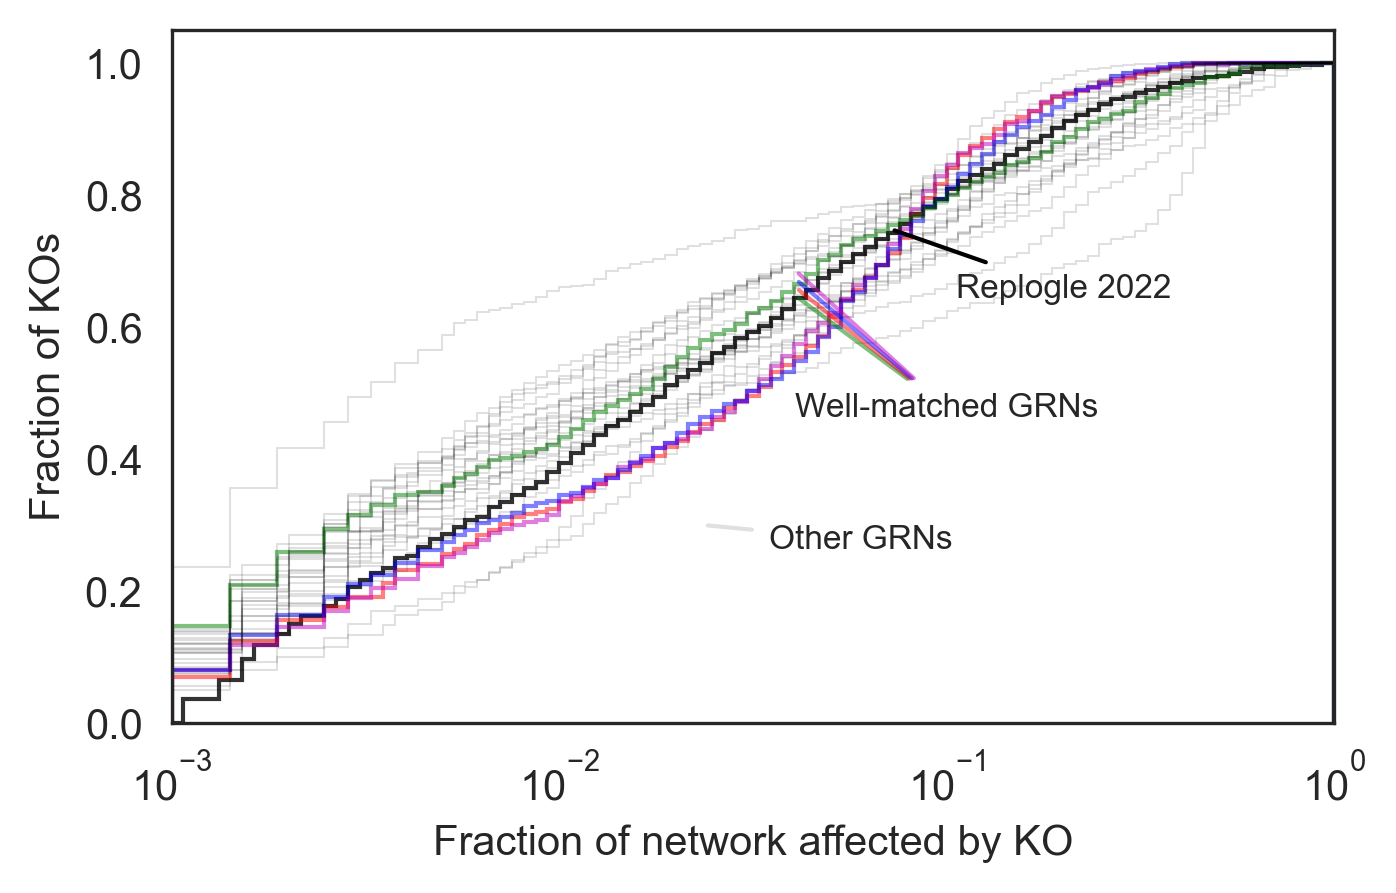

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(5,3), dpi=300);

for i,labels in enumerate([{'x':'Fraction of network affected by KO', 'y':'Fraction of KOs', 'col':'ko_array0', 'ps':ps_ko}]):
    for sim in range(1):
        _, bins, _ = ax.hist(labels['ps'],
                                alpha=0.8,
                                color='k',
                                histtype='step',
                                bins=np.logspace(-3,0,100),
                                cumulative=1,
                                density=1,
                                label='Replogle 2022' if sim==0 else '')

    for n,ix in enumerate(good_grns.index):
        ax.hist(networks.loc[ix, labels['col']],
                   alpha=0.5,
                   linewidth=1,
                   color='rmbg'[n],
                   histtype='step',
                   bins=bins, 
                   cumulative=1, 
                   density=1,
                   label='Well-matched GRNs' if n==0 else ' ')

    for n,ix in enumerate(other_grns.index): #
        ax.hist(networks.loc[ix, labels['col']],
                   alpha=0.12,
                   linewidth=0.5,
                   color='k',
                   histtype='step',
                   bins=bins, 
                   cumulative=1, 
                   density=1,
                   label='Other GRNs' if n==0 else '')    

    ax.semilogx();
    ax.set_xlim(1e-3, 1);
    ax.set_xlabel(labels['x'])
    ax.set_ylabel(labels['y'])

ax.annotate('Replogle 2022', 
            xy=(0.07,0.75), 
            xytext=(0.2, 0.68), # (2.2, 6e-5), (0.9e-4, 6e-5)
            fontsize=8, va='top', ha='center',
            arrowprops=dict(arrowstyle='-', facecolor='k', edgecolor='k')
            #arrowprops=dict(facecolor='blue', width=1, headlength=0.1, headwidth=0.1, shrink=0.1),
            );

for i,c in enumerate('grbm'):
    ax.annotate('Well-matched GRNs', 
                xy=(0.04,0.65+(0.013*i)), 
                xytext=(0.1, 0.5), # (2.2, 6e-5), (0.9e-4, 6e-5)
                fontsize=8, va='top', ha='center', alpha=0 if i else 1, 
                arrowprops=dict(arrowstyle='-', facecolor=c, edgecolor=c, alpha=0.5)
                #arrowprops=dict(facecolor='blue', width=1, headlength=0.1, headwidth=0.1, shrink=0.1),
                );

ax.annotate('Other GRNs', xy=(0.023,0.3), xytext=(0.06, 0.3), # (2.2, 6e-5), (0.9e-4, 6e-5)
            fontsize=8, va='top', ha='center', 
            arrowprops=dict(arrowstyle='-', facecolor='k', edgecolor='k', alpha=0.12)
            #arrowprops=dict(facecolor='blue', width=1, headlength=0.1, headwidth=0.1, shrink=0.1),
            );

#sns.despine();

# Supplement

## Effect of baseline transcription

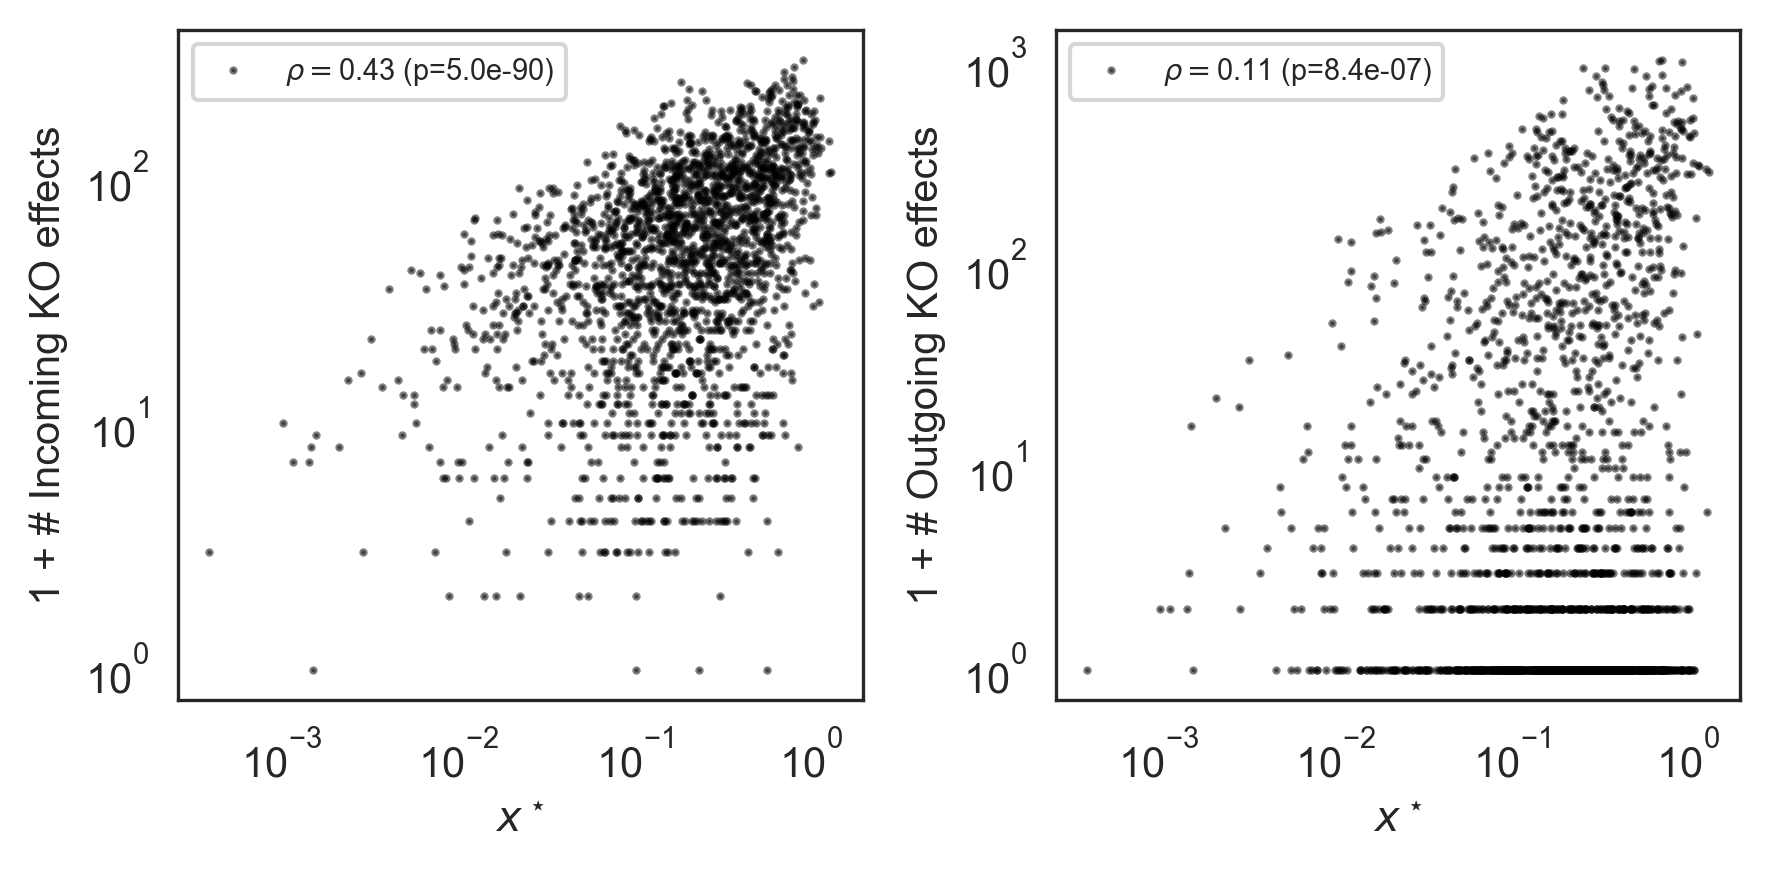

In [9]:
fig, ax = plt.subplots(1,2,figsize=(6,3),dpi=300);

grn=279
for i,yl in enumerate(['Incoming','Outgoing']):
    x = rna[grn,:][~lowE[grn,:]]
    y = (np.abs(ko[grn,:,:][np.ix_(~lowE[grn,:],~lowE[grn,:])]*x) > np.quantile(np.abs(ko[grn,:,:][np.ix_(~lowE[grn,:],~lowE[grn,:])]*x).flatten(), 1-q_ps)).sum(axis=i) + 1
    ax[i].plot(x, y, 'k.', alpha=0.5, ms=2);
    ax[i].loglog();
    ax[i].set_xlabel(r'$x^\star$');
    ax[i].set_ylabel('1 + # {0} KO effects'.format(yl));
    ax[i].legend([r'$\rho=$'+'{0:.2f} (p={1:.1e})'.format(*ss.spearmanr(x,y))], fontsize='x-small');

fig.tight_layout();

In [11]:
networks['in_out_rank_sum'] = networks[['tg_ks0','ko_ks0']].rank(ascending=False).sum(axis=1)
networks['in_out_rank_sum_rank'] = networks['in_out_rank_sum'].rank()
networks.head(2)

,files,n,k,r,delta_in,delta_out,w,tg_array0,ko_array0,tg_ks0,ko_ks0,pct_ko,k_adj,in_out_rank_sum,in_out_rank_sum_rank
1,/oak/stanford/groups/pritch/users/magu/project...,2000,1,2,10,1,1,"[0.03403403403403404, 0.04054054054054054, 0.0...","[0.7497497497497497, 0.8018018018018018, 0.849...",3.205643e-41,2.887712e-130,0.031445,2000,1903.5,1052.0
2,/oak/stanford/groups/pritch/users/magu/project...,2000,1,2,10,1,9,"[0.013006503251625813, 0.025512756378189096, 0...","[0.9809904952476238, 0.9584792396198099, 0.719...",1.240330e-34,1.170181e-57,0.031445,2000,1257.0,381.0


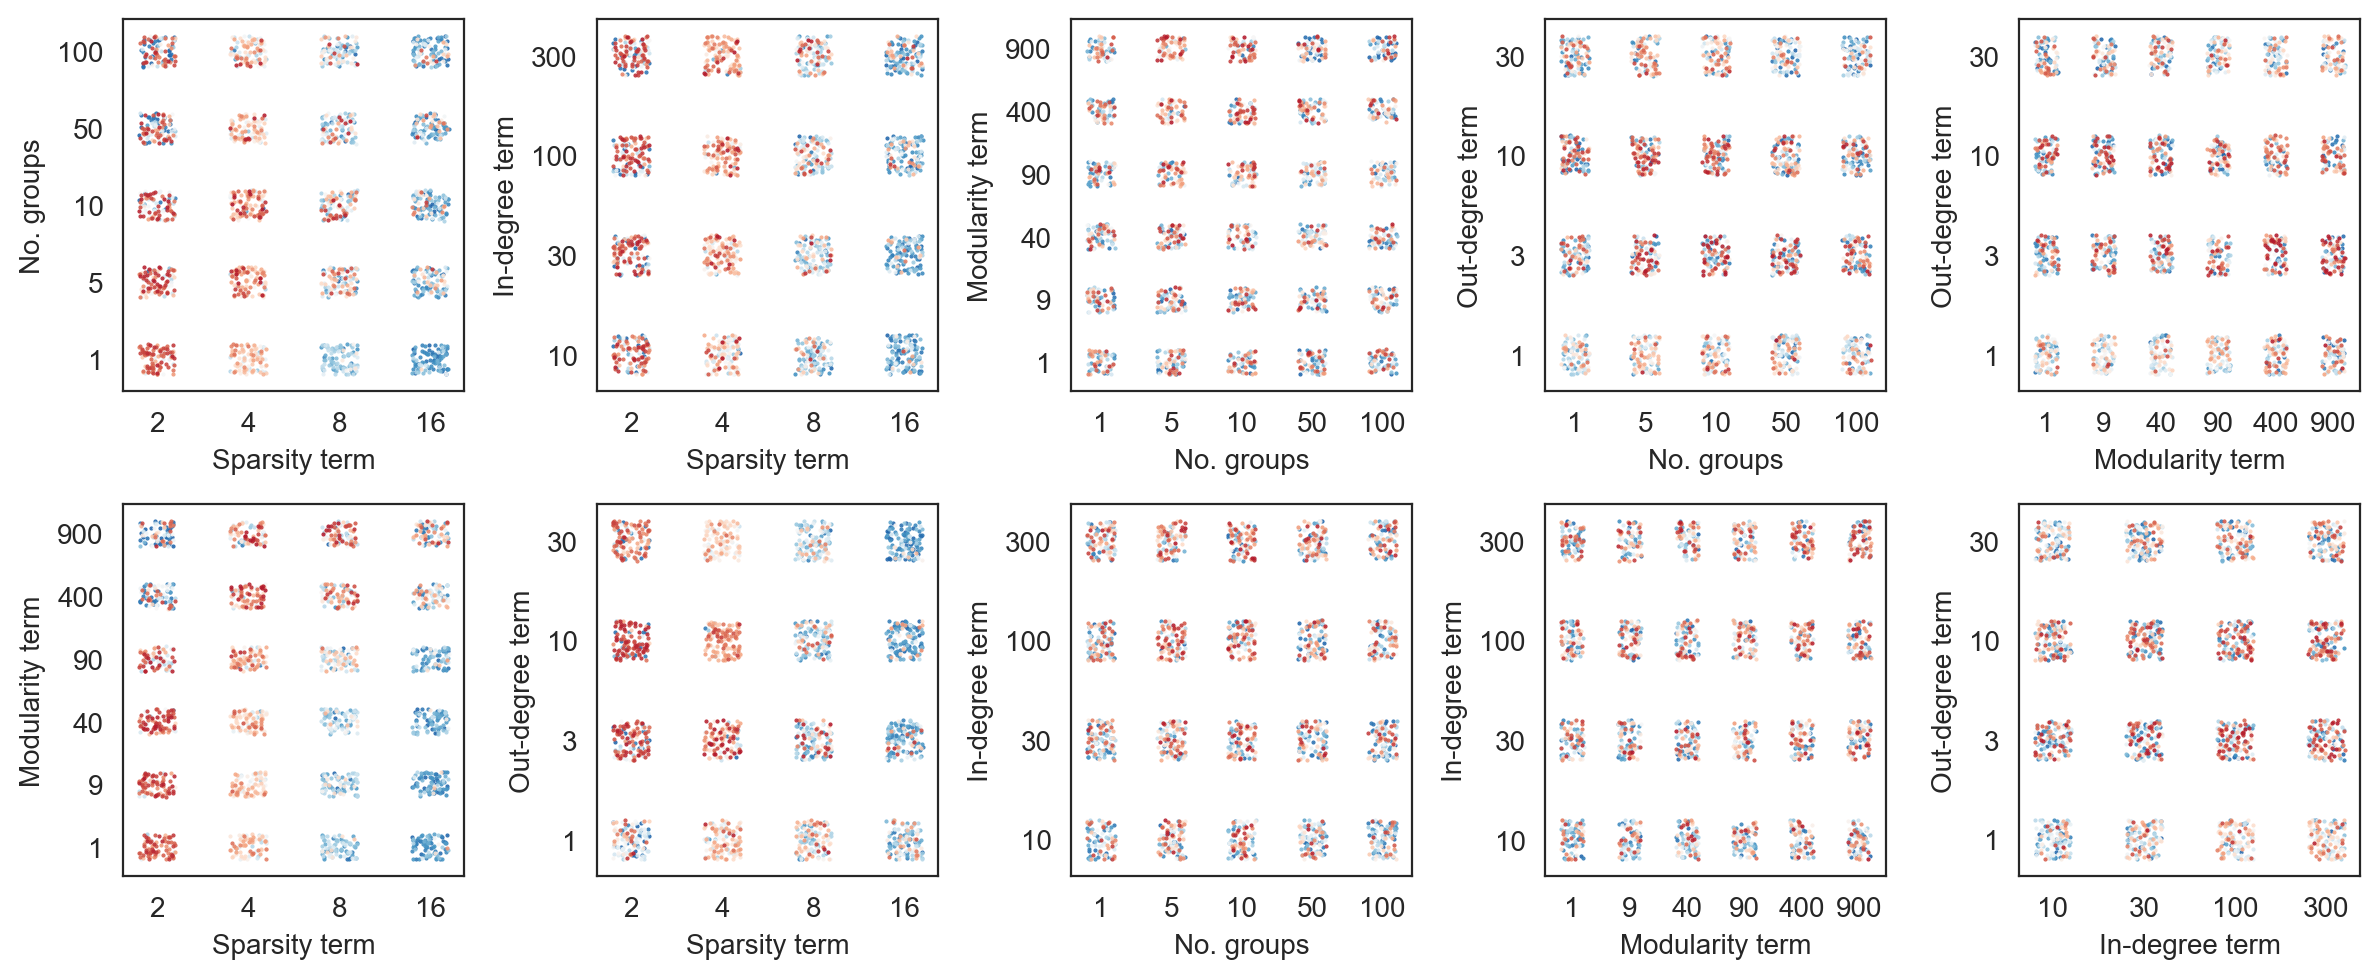

In [12]:
fig, axs = plt.subplots(2, 5, figsize=(12, 5), dpi=200);

a, b = networks['in_out_rank_sum_rank'].quantile((0,1)).values

labels = {'r':'Sparsity term', 
          'k':'No. groups', 
          'w':'Modularity term', 
          'delta_in':'In-degree term', 
          'delta_out':'Out-degree term'}

for i,(xc,yc) in enumerate(itertools.combinations(['r','k','w','delta_in','delta_out'], 2)):
    ax = axs.T[i // 2, i % 2]
    xvals = dict(map(reversed,enumerate(networks[xc].unique())))
    yvals = dict(map(reversed,enumerate(networks[yc].unique())))
    for _,(x,y,c) in networks[[xc, yc, 'in_out_rank_sum_rank']].sort_values('in_out_rank_sum_rank', ascending=False).iterrows():
        j = 0.2
        ax.plot(xvals[x] + j*np.random.uniform(-1, 1),
                yvals[y] + j*np.random.uniform(-1, 1),
                '.', ms=1, alpha=0.9,
                color=plt.cm.get_cmap('RdBu')(0.1 + 0.8*(c-a)/(b-a)))
    ax.set_xlabel(labels[xc]);
    ax.set_ylabel(labels[yc]);
    ax.set_xticks(range(len(xvals)));
    ax.set_xticklabels(list(xvals.keys()));
    ax.set_yticks(range(len(yvals)));
    ax.set_yticklabels(list(yvals.keys()));

fig.tight_layout();
plt.savefig('png/supplement/fig_s5a.png');
plt.show()

In [13]:
networks.loc[good_grns.index]

,files,n,k,r,delta_in,delta_out,w,tg_array0,ko_array0,tg_ks0,ko_ks0,pct_ko,k_adj,in_out_rank_sum,in_out_rank_sum_rank
677,/oak/stanford/groups/pritch/users/magu/project...,2000,10,4,100,3,400,"[0.04315102860010035, 0.06071249372804817, 0.0...","[0.10938283993978926, 0.16056196688409433, 0.3...",2.302696e-21,1.504814e-12,0.031445,10,208.0,4.0
678,/oak/stanford/groups/pritch/users/magu/project...,2000,10,4,100,3,900,"[0.0405811623246493, 0.06162324649298597, 0.03...","[0.1497995991983968, 0.001503006012024048, 0.5...",3.106536e-12,6.954397e-13,0.031445,10,116.0,1.0
647,/oak/stanford/groups/pritch/users/magu/project...,2000,10,4,30,3,400,"[0.10165247871807712, 0.05658487731597396, 0.0...","[0.02103154732098147, 0.43164747120681024, 0.1...",7.869317e-16,2.317518e-14,0.031445,10,195.0,3.0
1014,/oak/stanford/groups/pritch/users/magu/project...,2000,50,8,30,1,900,"[0.03651825912956478, 0.0005002501250625312, 0...","[0.8314157078539269, 0.8929464732366184, 0.136...",1.502457e-21,9.660703e-14,0.031445,50,252.0,5.0


In [14]:
for stat in ['r','k','w','delta_in','delta_out']:
    print(networks.sort_values('in_out_rank_sum').head(100)[stat].value_counts())

2     57
4     26
8     16
16     1
Name: r, dtype: int64
10     33
5      28
50     22
100    10
1       7
Name: k, dtype: int64
900    22
400    20
90     17
40     17
9      15
1       9
Name: w, dtype: int64
100    29
300    28
30     26
10     17
Name: delta_in, dtype: int64
3     55
10    36
1      6
30     3
Name: delta_out, dtype: int64
